# TD3
# 💦🏊🏽‍♀️ Piquer une tête dans les plongements


3 étapes :
- charger un plongement Word2Vec précalculé 
- écrire une fonction qui trouve les voisins d'un mot = ses mots les plus proches
- explorer les analogies


#### charger le word2vec précalculé 
  - chercher frwiki-50k_100d.txt sur google drive et le mettre à côté de votre notebook.
  - c'est une réduction à 50k types les plus fréquents du word2vec complet https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ 
  - ouvrir le fichier et comprendre le format
  - 🚧 écrire une fonction `read_vectors` qui donne une matrice numpy `embeddings` avec une ligne par type (~ un mot), chaque ligne représente le mot. `embeddings[i,:]` correspond à un type.

In [ ]:
# on télécharge le fichier
# mettre les lignes suivantes en commentaire une fois que le fichier est téléchargé ou pris manuellement
!wget https://gerdes.fr/saclay/enwiki-50k_100d.zip
!unzip enwiki-50k_100d.zip

### 🚧 TODO: expliquer
- combien de colonnes a ce tableau ?
- combien de lignes ?
- que contient la première colonne ?
- les lignes sont dans quel ordre ?

#### réponses:
- 101
- 50k (+1 vide)
- le token
- par fréquence du type

In [1]:
infile = 'frwiki-50k_100d.txt'
inf = open(infile)
a = [float(x) for x in inf.readline().split()[1:]]
b = [float(x) for x in inf.readline().split()[1:]]
np.linalg.norm(a),np.linalg.norm(b)

FileNotFoundError: [Errno 2] No such file or directory: 'frwiki-50k_100d.txt'

In [157]:
import re, json
import numpy as np
from collections import Counter
from sklearn import decomposition
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [18]:
def read_vectors(infile, vocab_size=50000, dimension=100):
    """
    fonction qui lit une sauvegarde d'un plongement
    retourne 
    - un dictionnaire word type -> index
    - le dictionnaire inverse
    - une matrice contenant un vecteur de mot par word type
    """
    embeddings = np.zeros((vocab_size, dimension))
    w2i, i2w = {}, {}
    i = 0
    for line in open(infile):
        # 🚧 TODO:
        # ...
        splitted = line.strip().split()
        w2i[splitted[0]] = i
        i2w[i] = splitted[0]
        embeddings[i] = np.array(splitted[1:], dtype=float)
        i+=1
        # fin TODO
    assert len(w2i)==len(i2w)==len(embeddings)
    return w2i, i2w, embeddings

w2i, i2w, embeddings = read_vectors('frwiki-50k_100d.txt')
print(len(w2i),len(i2w),embeddings.shape)

50000 50000 (50000, 100)


# 👬 Les mots les plus similaires
### Objectifs
On veut faire une fonction python `find_closest_words_from_word` qui pour un mot donné retourne les K plus proches voisins (sémantiques).

Pour ce faire, il faudra 
1. calculer la distance cosinus entre eux
2. ordoner les distances par ordres decroissants


#### 1. Calcul de la distance cosinus
**Astuce**, on peut faire ceci en deux sous-étapes : 
- 🚧 normaliser les embeddings (par rapport aux lignes, càd chaque vecteur de mot à une norme unitaire)
- 🚧 calculer produit scalaire entre l'embedding du mot source avec l'espace d'embedding entier

In [19]:
# TODO : normaliser les embeddings (par rapport aux lignes, càd chaque vecteur de mot à une norme unitaire)
normed_embeddings = embeddings/(np.linalg.norm(embeddings, axis=1)).reshape(-1, 1)
#normed_embeddings = # 🚧 TODO: ...??

**⚠ Achtung !!!** : Pour simplifier les calculs par la suite, on basera nos calculs sur la matrice `normed_embeddings`. De ce fait, on n'aura pas besoin de diviser le produit scalaire des deux vecteurs par leurs normes (la similarité cosinus de deux vecteurs unitaires est juste le produit scalaire des vecteurs).

Si vous souhaitez effectuer un calcul de similarité basé sur une autre mesure (distance euclidienne ?), alors vous devrez baser vos calculs sur la matrice `embeddings` brute (qui n'est pas normalisée !)

In [20]:
def find_closest_words_from_vector(vector, K=10):
    """Pour un vecteur donné, trouve les K plus proches voisins sémantiques"""
    closest_words = []
    
    cosine_similarities = np.dot(vector, normed_embeddings.T)
#     cosine_similarities = # 🚧 TODO: ...?? pensez au produit scalaire
    
    sorted_indexes = cosine_similarities.argsort() # matrice trié du plus petit au plus grand 
#     sorted_indexes =  # 🚧 TODO: ...?? matrice trié du plus petit au plus grand 
   
    # Seulement K plus grands nous interesse
    for k in range(1, K+1): # pour prendre les derniers éléments, on commence par -1
        # 🚧 TODO: ...??
        neighboor_index = sorted_indexes[-k]
        closest_words.append((i2w[neighboor_index], cosine_similarities[neighboor_index]))
        # fin todo
    return closest_words

In [21]:
def find_closest_words_from_word(word, K=10):
    """Pour un mot 'word' donné, trouve les K plus proches voisins sémantiques"""
    word_index = w2i[word]
#     word_index = # 🚧 TODO: ...??
    word_vector = normed_embeddings[word_index]
#     word_vector = # 🚧 TODO: ...??
    closest_words = find_closest_words_from_vector(word_vector)
    return closest_words

In [22]:
def pretty_show(closest_words):
    """prettify the print for the closest words"""
    for word, similarity in closest_words:
        print(word.ljust(15, ' '), similarity.round(3))
    print("___\n")

In [23]:
# Creative time ! Testons notre fonction sur certains termes
pretty_show(find_closest_words_from_word("français")) # notez comment un plongement peut être utilisé pour normaliser l'orthographe. notez aussi que l'allemand est plus proche du français que marseillais :)
pretty_show(find_closest_words_from_word("fusée"))
pretty_show(find_closest_words_from_word("purée")) # c'est entraîné sur Wikipédia. --> peu de jurons...
pretty_show(find_closest_words_from_word("mince"))

français        1.0
francais        0.705
anglais         0.696
italien         0.673
québecois       0.663
allemand        0.662
naturalisé      0.651
réunionnais     0.647
marseillais     0.645
québécois       0.639
___

fusée           1.0
fusées          0.857
propulseurs     0.807
tuyère          0.783
propulseur      0.779
ergols          0.761
soyouz          0.757
missile         0.756
balistique      0.747
propulsion      0.744
___

purée           1.0
soupe           0.841
confiture       0.823
frites          0.792
beurre          0.791
salade          0.789
pâte            0.782
noix            0.782
pommes          0.777
haricots        0.775
___

mince           1.0
épaisse         0.837
épais           0.794
lisse           0.789
minces          0.78
aplati          0.771
translucide     0.763
rugueuse        0.757
aplatie         0.757
imperméable     0.757
___



## ▱ Analogies
finalement les jolies analogies dans les plongements !

In [52]:
def find_analogies(wpos1, wpos2, wneg):
    """
    wpos1: le premier mot positif, wpos2: le 2e mot positif, wneg: le mot négatif
    trouve l'analogie 'analog' tel que <'analog' est à 'wpos2' ce que 'wneg' est à 'wpos1'>
    Par exemple : <"reine" est à "femme" ce que "roi" est à "homme">
    """
    # additionner les vecteurs positifs, substraire le vecteur négatif :
    vector_analog  = normed_embeddings[w2i[wpos1]] + normed_embeddings[w2i[wpos2]] - normed_embeddings[w2i[wneg]]
#     vector_analog  = ... # 🚧 todo
    return find_closest_words_from_vector(vector_analog)

# exppliquer pourquoi cette assert échoue :
# assert find_analogies("roi", "femme", "femme")  == find_closest_words_from_word("roi")


In [53]:
### réponse :
print(find_analogies("roi", "femme", "femme")  == find_closest_words_from_word("roi"))
print(find_analogies("roi", "femme", "femme"))
print(find_closest_words_from_word("roi"))
# il y a une petite différence à cause d'une erreur d'arrondi

# pour info :
# si vous voulez comparer approximativement, allez voir https://numpy.org/doc/stable/reference/routines.testing.html
# on y trouve assert_almost_equal et assert_allclose
# là, ça passe :
wpos1, wpos2, wneg = "roi", "femme", "femme"
np.testing.assert_allclose(normed_embeddings[w2i[wpos1]] + normed_embeddings[w2i[wpos2]] - normed_embeddings[w2i[wneg]], normed_embeddings[w2i[wpos1]])

False
[('roi', 1.0000000000000002), ('rois', 0.7881373069475803), ('souverain', 0.7857795052485643), ('régent', 0.7741236418333175), ('monarque', 0.767470785358407), ('trône', 0.7673425980544224), ('reine', 0.7591940381637095), ('chambellan', 0.748808740786574), ('ier', 0.7282150467883074), ('suzerain', 0.7256096883917855)]
[('roi', 1.0000000000000002), ('rois', 0.7881373069475803), ('souverain', 0.7857795052485643), ('régent', 0.7741236418333175), ('monarque', 0.767470785358407), ('trône', 0.7673425980544224), ('reine', 0.7591940381637093), ('chambellan', 0.748808740786574), ('ier', 0.7282150467883073), ('suzerain', 0.7256096883917856)]


#### on commence avec les grands classiques :

In [93]:
pretty_show(find_analogies("roi", "femme", "homme"))
pretty_show(find_analogies("infirmière", "homme", "femme")) # attention au biais. 
# 🚧 todo: trouver 3 autres exemples "douteux"
pretty_show(find_analogies("amant", "femme", "homme"))
pretty_show(find_analogies("nourrice", "homme", "femme"))
pretty_show(find_analogies("maitresse", "homme", "femme"))
pretty_show(find_analogies("charpentier", "femme", "homme"))


reine           1.106
roi             1.001
régente         0.981
princesse       0.906
concubine       0.906
maitresse       0.902
douairière      0.897
consort         0.892
maîtresse       0.887
sœur            0.881
___

médecin         0.802
éducateur       0.792
chirurgien      0.775
infirmier       0.771
pharmacien      0.768
psychiatre      0.765
psychologue     0.758
politicien      0.749
avocat          0.749
homme           0.747
___

amant           1.073
sœur            1.059
amie            1.058
amante          1.048
maîtresse       1.045
fiancée         1.019
tante           1.013
servante        1.012
nourrice        1.012
compagne        1.005
___

homme           0.67
serviteur       0.668
aubergiste      0.663
vieillard       0.649
cordonnier      0.643
nourrice        0.635
garçon          0.631
père            0.63
mendiant        0.622
percepteur      0.62
___

homme           0.658
neveu           0.656
gendre          0.648
maitresse       0.647
admirateur     

In [111]:
# on peut aussi jouer avec des nationalités
pretty_show(find_analogies("avenue", "allemand", "français")) # cool
pretty_show(find_analogies("vin", "russe", "français")) # cool
pretty_show(find_analogies("vin", "allemand", "français")) # pas mal - parfois le premier mot est simplement l'un des deux mots positifs
pretty_show(find_analogies("vin", "marocain", "français")) # pas mal
pretty_show(find_analogies("croissant", "italien", "français")) # étrange
pretty_show(find_analogies("pizza", "français", "italien")) # pas mal
pretty_show(find_analogies("amour", "italien", "français")) # pas mal
pretty_show(find_analogies("aimer", "allemand", "français")) # hmmm

straße          0.932
avenue          0.892
platz           0.841
boulevard       0.768
haus            0.766
rue             0.727
lavenue         0.7
bundesstraße    0.693
stadt           0.691
quartier        0.685
___

vodka           0.913
vin             0.897
raisin          0.787
glacée          0.78
kouban          0.777
yaourt          0.776
fermenté        0.772
alcoolisées     0.766
jus             0.761
liqueurs        0.76
___

vin             0.939
bière           0.781
jus             0.776
houblon         0.756
moût            0.746
breuvage        0.741
vodka           0.738
vinaigre        0.737
raisin          0.732
cépage          0.72
___

vin             0.88
dattes          0.807
riz             0.768
sucré           0.766
olives          0.756
lait            0.755
fruité          0.748
parfumé         0.742
fermenté        0.741
ragoût          0.723
___

vin             0.968
riz             0.903
fermenté        0.864
nectar          0.848
jus             0.

In [95]:
# 🚧 todo: trouver 3 autres exemples où la féminisation fonctionne :
pretty_show(find_analogies(..., "femme", "homme"))
pretty_show(find_analogies(..., "femme", "homme"))
pretty_show(find_analogies(..., "femme", "homme")) 
# solution par exemple 
pretty_show(find_analogies("président", "femme", "homme"))
pretty_show(find_analogies("chercheur", "femme", "homme"))
pretty_show(find_analogies("chanteur", "femme", "homme")) 
pretty_show(find_analogies("gardien", "femme", "homme"))


présidente      0.964
présidence      0.926
président       0.865
représentante   0.838
directrice      0.806
secrétaire      0.774
maîtresse       0.773
collaboratrice  0.772
ambassadrice    0.772
marraine        0.765
___

chercheuse      0.896
professeure     0.881
assistante      0.837
chercheur       0.831
enseignante     0.829
directrice      0.797
doctorant       0.789
historienne     0.787
collaboratrice  0.781
documentaliste  0.776
___

chanteuse       0.997
musicienne      0.908
choriste        0.899
chanteur        0.852
interprète      0.85
compositrice    0.846
chanteuses      0.846
danseuse        0.836
compagne        0.834
chante          0.825
___

gardienne       1.048
gardien         0.977
doublure        0.815
servante        0.814
gardiens        0.814
maitresse       0.808
maîtresse       0.792
nourrice        0.785
fiancée         0.78
portier         0.776
___



pour terminer
# 💥 classification de textes à l'aide d'un plongement

In [121]:
retoken = re.compile(r"\w+")

def doc2vec(text):
    """
    la fonction prend un texte, découpe en tokens
    pour chaque token, si le token est dans w2i, on prend son vecteur
    on additionne les vecteurs et on renormalise
    la fonction retourne un vecteur du même format que ceux qu'on a pour chaque mot
    """
    tokens = retoken.findall(text)
    vectors = [normed_embeddings[w2i[t]] for t in tokens if t in w2i]
    somme = sum(vectors)
    normalisé = somme / np.sqrt(np.sum(somme**2))
    return normalisé



# 🚧 todo: expliquer pourquoi ceci passe :
np.testing.assert_allclose( doc2vec('voyons comment ça fonctionne, ce word2vec truc') , doc2vec('voyons comment ça fonctionne ce truc !'))
# réponse :
# ni mots inconnus ni ponctuation sont pris en compte

vex = doc2vec('voyons comment ça fonctionne, ce word2vec truc')
vex

array([-0.05193382, -0.03537372,  0.02347292, -0.06173468,  0.04946966,
       -0.0831721 ,  0.08459478, -0.02742789, -0.05417082,  0.02654042,
       -0.0510772 ,  0.04404778,  0.02308071, -0.00573468, -0.00596354,
        0.30417018, -0.03556988,  0.03314974, -0.09479043, -0.0316145 ,
       -0.04641283,  0.04299522,  0.12396535,  0.24492167,  0.07859509,
       -0.05637844,  0.08317643, -0.08548407, -0.23921097, -0.0221057 ,
       -0.0107561 , -0.11938176,  0.07067784, -0.05368603,  0.145802  ,
       -0.02024793, -0.01206741, -0.12358578,  0.01572195,  0.09785335,
        0.146049  , -0.02284181,  0.12634421, -0.02435245, -0.1140478 ,
        0.1445227 , -0.06401598, -0.07563074,  0.06868681, -0.08011854,
        0.09415428,  0.00385685, -0.09971027, -0.12257501,  0.02886528,
        0.01656   , -0.05007022, -0.14712955, -0.10079639, -0.07694216,
        0.04420331, -0.10192207,  0.10108319, -0.14784448,  0.077666  ,
       -0.03834645, -0.22538331,  0.08167304,  0.1791027 ,  0.04

### on charge notre corpus de sous-titres des vidéos Youtube

- rappel : 
    - le fichier est en format json, 
        - si ce n'est pas claire regardez le fichier dans un éditeur de texte
    - les texts sont sous l'entrée `text`, les catégories qu'on souhaitera prédire est sous l'entrée `category`
- on traduit chaque texte dans un vecteur à l'aide de notre fonction doc2vec

In [127]:
videos = json.loads(open('french_yt_videos.json').read())
texts = [text['text'] for text in videos ]   
text_vex = [doc2vec(text['text'].lower()) for text in videos ]   
ys = [text['category'] for text in videos ]  
target_names = sorted(set(ys))
print(Counter(ys), 'total:',len(text_vex))

Counter({'Comedy': 66, 'Entertainment': 46, 'News & Politics': 40, 'People & Blogs': 30, 'Howto & Style': 29, 'Science & Technology': 24, 'Film & Animation': 19, 'Music': 13, 'Sports': 8, 'Nonprofits & Activism': 7, 'Gaming': 5, 'Travel & Events': 3, 'Pets & Animals': 1, 'Autos & Vehicles': 1}) total: 292


### on visualise nos textes à l'aide d'une PCA

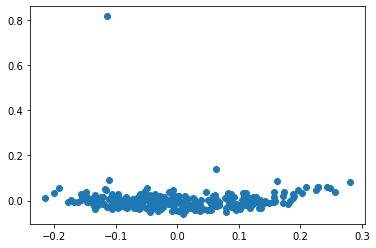

In [128]:
pca = decomposition.PCA(n_components=2)
pca.fit(text_vex)
text_vex_2d = pca.transform(text_vex)
x, y = text_vex_2d.T
plt.figure()
plt.scatter(x, y )

#### 🚧 TODO:
- trouver ce texte qui nous perturbe notre jolie PCA
- expliquer en quoi le texte est bizarre
- le virer de notre dataset
- visualiser à nouveau la PCA

In [134]:
df2d = pd.DataFrame(text_vex_2d,columns=['x','y'])
df2d['label']=ys
df2d

x         y                 label
0    0.019061 -0.026204         Howto & Style
1    0.025909  0.009326  Science & Technology
2    0.224568  0.048843       News & Politics
3   -0.114032 -0.029367        People & Blogs
4   -0.058272 -0.013339                Comedy
..        ...       ...                   ...
287 -0.044436  0.016265  Science & Technology
288  0.055216 -0.043352       News & Politics
289 -0.036025 -0.006507         Entertainment
290 -0.083939 -0.011915                Comedy
291 -0.134548  0.022588         Entertainment

[292 rows x 3 columns]

In [135]:
df2d[y>0.6]

x         y          label
21 -0.114768  0.817874  Howto & Style

In [143]:
i=df2d[y>0.6].index[0]
texts[i][:999]

"Hi, welcome to my home I am Joy Van Der Eecken, Belgian who has been living in Paris for three years. Today, ParisianVibe invited me to make a video about trendy hairstyles for this summer. So, I invited my friend Cyril, a top hairstylist who is going to help me today. You will discover some new summer hairstyles today. I invite you to wait a little bit and watch until the end... I think he's here, let's go! Hi Joy, how are you? Good and you? Good. Follow me in the living room, there is enough light there I'm Cyril, hairstylist from Paris. Today, together with Joy, we will show you 5 hairstyles for summer. Let's start. I would like to create a very natural wavy hair look. To make it happen I like to use salt spray. I really like. That way, it gives you a little texture, the idea is not to put too much It's really just about adding a little more texture to your hair. Yes, to make it look more natural The second stage of this process is to dry your hair. I don't dry with too hot air. So

#### réponse : c'est une vidéo en anglais parmi des vidéos françaises

In [138]:
# le virer
print(len(videos))
videos = videos[:i]+videos[i+1:]  
print(len(videos))

292
291


In [144]:
texts = texts[:i]+texts[i+1:] 
text_vex = text_vex[:i]+text_vex[i+1:]  
ys = ys[:i]+ys[i+1:]  
print(len(ys))

291


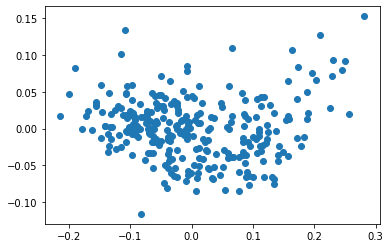

In [145]:
# 🚧 todo : fitter et afficher à nouveau
pca.fit(text_vex)
text_vex_2d = pca.transform(text_vex)
x1, x2 = text_vex_2d.T
plt.figure()
plt.scatter(x1, x2)

### avec les classes de vidéos :

Text(0.5, 1.0, "Voici tous les textes de vidéos. ça a l'air compliqué...")

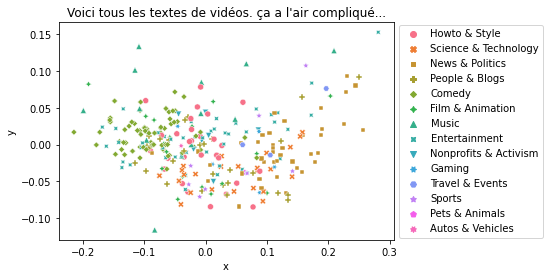

In [149]:
df2d = pd.DataFrame(text_vex_2d,columns=['x','y'])
df2d['label']=ys
g = sns.scatterplot(x="x", y="y", data=df2d, hue="label", style="label")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.set_title("Voici tous les textes de vidéos. ça a l'air compliqué...")

### comme avant, essayons de distinguer 3 groupes seulement
- Science & Technology, News & Politics et Comedy (snc)
- c'est une tâche qui parait faisable
- en plus ça nous plait car la science semble se trouver qqpart entre les news et la comédie :)

In [150]:
snc = ['Science & Technology', 'News & Politics', 'Comedy']
snc_texts = [t for t,y in zip(texts,ys) if y in snc] 
snc_text_vex = [t for t,y in zip(text_vex,ys) if y in snc]   
snc_ys = [y for y in ys if y in snc]
assert len(snc_texts)==len(snc_ys)
len(snc_texts)

130

In [151]:
pca.fit(text_vex)
snc_text_vex_2d = pca.transform(snc_text_vex)
df2d = pd.DataFrame(snc_text_vex_2d,columns=['x','y'])
df2d['label']=snc_ys
df2d.head()

x         y                 label
0  0.025988 -0.015802  Science & Technology
1  0.225706  0.028387       News & Politics
2 -0.058894 -0.014788                Comedy
3  0.230232  0.093390       News & Politics
4  0.125199 -0.004339       News & Politics

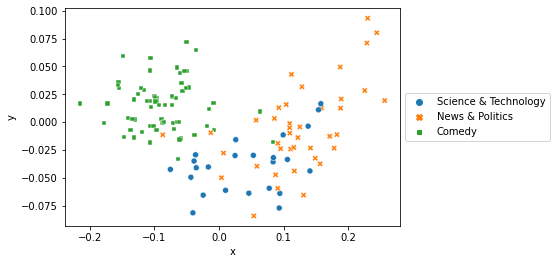

In [155]:
g = sns.scatterplot(x="x", y="y", data=df2d, hue="label", style="label")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

- ça a l'air faisable, mais pas forcément mieux parti que pour Tf-Idf.

### 🚧 todo :
- faire une validation croisée et comparer avec les résultats de Tf-Idf

In [163]:
model = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(model, snc_text_vex_2d, snc_ys, cv=5)
print(scores)
print(scores.mean())

[0.76923077 0.84615385 0.69230769 0.92307692 0.76923077]
0.8


### réponse :
- Tf-Idf donne des meilleurs résultats, même si le calcul est bcp plus simple
- notez que notre caclul de Doc2Vec est très simple et marche mieux sur des textes courts.

____

# 👏🌹😎

- la suite dans le cours Hands-On NLP en Master 1...